<h1><center>Physique numérique (PHY-3500) - TP3</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Atténuation des rayons X

1) *Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l’eau pour des photons de 60 keV, à une masse volumique de 1.0 g/cm³. Quelle fraction du signal subsiste après avoir traversé 5 cm d’eau ; 20 cm d’eau ?*

Pour commencer, il faut calculer le coefficient d'atténuation $\mu$ de l'eau pour des photons de 60 keV et ensuite déterminer la fraction du signal qui subsiste après avoir traversé 5 cm et 20 cm d'eau. Pour trouver $\mu$ pour l'eau à 60 keV, nous utiliserions normalement la base de données XCOM du NIST. Typiquement, $\mu$ pour l'eau à 60 keV est environ $0.2 \rm cm^{-1}$. Ensuite, en utilisant la loi de Beer-Lambert, l'intensité $I$ des rayons X après avoir traversé un matériau est donnée par :
$$I = I_0e^{-\mu x} \ ,$$

où $I_0$ est l'intensité initiale, $\mu$ est le coefficient d'atténuation linéaire et $x$  est l'épaisseur du matériau en cm. La fraction du signal restant est donc donnée par :
$$F_I = \frac{I}{I_0} = e^{-\mu x} \ .$$

In [2]:
mu_w = 0.2              # valeur typique pour l'eau à 60 keV en cm^-1
t = np.asarray((5, 20)) # épaisseurs en cm

# Calcul de la fraction d'intensité restante pour 5 cm et 20 cm d'eau
f = np.exp(-mu_w * t)

print(f"Fraction d'intensité restante après 5 cm d'eau : {f[0]}")
print(f"Fraction d'intensité restante après 20 cm d'eau : {f[1]}")

Fraction d'intensité restante après 5 cm d'eau : 0.36787944117144233
Fraction d'intensité restante après 20 cm d'eau : 0.01831563888873418


# Reconstruction par rétroprojection

2) En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée laminogramme, des données de projection fournies. Notez qu’une approche par slicing pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur). Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image de référence (fantôme) ?


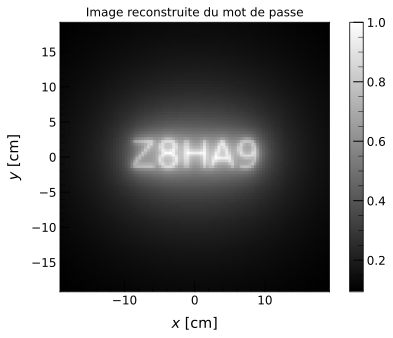

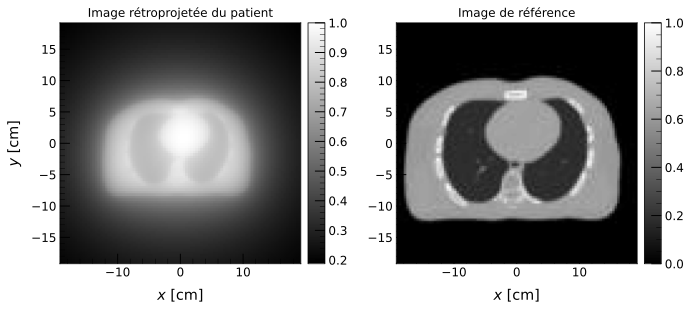

In [3]:
def retroprojection(sinogram: NDArray, angles: NDArray, size: int) -> NDArray:
    """Rétroprojection simple avec l'interpolation du plus proche voisin.

    Paramètres
    ----------
        sinogram
            Données du sinogramme (2D) où chaque ligne correspond à une
            projection à un angle spécifique.
        angles
            Angles en radians auxquels les projections ont été prises.
        size
            Taille de l'image de sortie carrée, spécifiant la résolution de
            l'image reconstruite.

    Retourne
    --------
        img
            Image reconstruite par rétroprojection à partir des projections
            dans le sinogramme.

    """
    # Initialisation de l'image de sortie
    img = np.zeros(size, dtype=np.float32)

    # Création d'une grille de coordonnées pour l'image de sortie
    x = np.linspace(1, -1, size[0])
    y = np.linspace(-1, 1, size[1])
    grid_x, grid_y = np.meshgrid(x, y)

    angles = np.radians(angles)
    for angle, proj in zip(angles, sinogram):
        # Calcul des coordonnées de la ligne de projection pour l'angle courant
        t = grid_x * np.cos(angle) + grid_y * np.sin(angle)

        # Mise à l'échelle de 't' pour mapper aux indices du tableau de proj
        t_scaled = np.interp(t, (-1, 1), (0, proj.size - 1))

        # Accumulation des valeurs interpolées du sinogramme dans l'image
        img += np.interp(t_scaled, np.arange(proj.size), proj, left=0, right=0)

    # Normalisation de l'image
    img /= img.max()
    return img


# Chargement des angles et des données du sinogramme
angles = np.loadtxt("data/angles.txt")
psw = np.loadtxt("data/sinogram-password.txt")
patient = np.loadtxt("data/sinogram-patient.txt")

pix_size = 0.4
size = np.asarray((96, 96))
scale_x, scale_y = size * pix_size / 2
ax_lims = np.asarray((-scale_x, scale_x, -scale_y, scale_y))

# Réalisation de la rétroprojection
img_psw = retroprojection(psw, angles, size)
img_patient = retroprojection(patient, angles, size)
img_ref = plt.imread("data/phantom-thorax-096-smooth.png")

# Affichage de l'image reconstruite du mot de passe
plt.imshow(img_psw, cmap="gray", extent=ax_lims)
plt.title("Image reconstruite du mot de passe")
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")
plt.colorbar()
plt.show()

# Affichage des images reconstruites
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
kwargs = {"cmap": "gray", "extent": ax_lims}
axs[0].set_ylabel("$y$ [cm]")
axs[0].set_title("Image rétroprojetée du patient")
axs[1].set_title("Image de référence")

# Ajustement de la taille des colorbar
imgs = img_patient, img_ref
for n, ax in enumerate(axs.flat):
    ax.set_xlabel("$x$ [cm]")
    ax_div = make_axes_locatable(ax)
    cax = ax_div.append_axes("right", size="7%", pad="3%")
    im = ax.imshow(imgs[n], **kwargs)
    fig.colorbar(im, cax=cax)

plt.tight_layout(pad=2)
plt.show()

# Rétroprojection filtrée

3) *En utilisant la librairie numpy.fft, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré ?*

Le filtre de rampe compense la perte des hautes fréquences due à l'intégration des rayons X dans le processus de mesure de l'atténuation, ce qui résulte en général dans une image plus nette et plus précise. En termes mathématiques, le filtre de rampe multiplie la transformée de Fourier de chaque projection par la fréquence absolue.

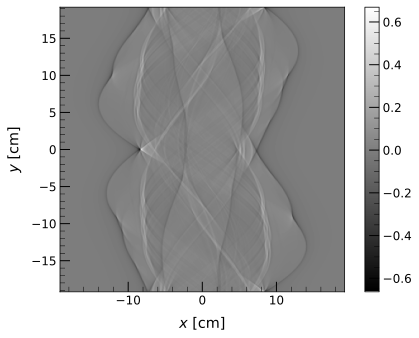

In [4]:
def ramp_filter(sinogram: NDArray, spacing: int | float = 1) -> NDArray:
    """Applique un filtre de rampe (passe-haut) à la FFT du sinogramme.

    Parameters
    ----------
        sinogram
            Données du sinogramme.
        spacing
            Espacement des pixels dans le sinogramme.

    Retourne
    --------
        filt_sin
            Sinogramme après l'application du filtre.

    """
    # Facteur d'échelle de fréquence dans le domaine de Fourier
    freqs = np.fft.fftfreq(sinogram.shape[1], d=spacing)

    # Construction du filtre en rampe dans le domaine de Fourier
    ramp = np.abs(freqs)

    # Appliquer le filtre en rampe pour chaque projection
    filt_proj = np.fft.fft(sinogram) * ramp
    filt_sin = np.fft.ifft(filt_proj).real

    return filt_sin


# Filtrage des rétroprojections
patient_filt = ramp_filter(patient, 0.4)

plt.imshow(patient_filt, **kwargs)
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")
plt.colorbar()

# Sauvegarde de l'image avec les paramètres du fichier 'LabReport.mplstyle'
# plt.savefig("filtered-sinogram")

# Affichage du sinogramme filtrée
plt.show()

4) Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant
idéalement le code précédent du laminogramme. Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Ou sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs ?


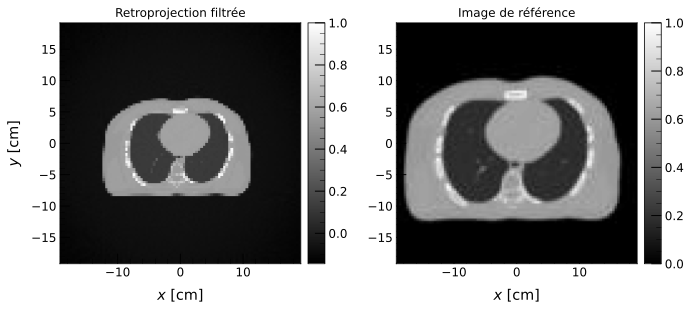

In [5]:
img_patient_filt = retroprojection(patient_filt, angles, size)

# Affichage des images reconstruites
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_ylabel("$y$ [cm]")
axs[0].set_title("Retroprojection filtrée")
axs[1].set_title("Image de référence")

# Ajustement de la taille des colorbar
imgs = img_patient_filt, img_ref
for n, ax in enumerate(axs.flat):
    ax.set_xlabel("$x$ [cm]")
    ax_div = make_axes_locatable(ax)
    cax = ax_div.append_axes("right", size="7%", pad="3%")
    im = ax.imshow(imgs[n], **kwargs)
    fig.colorbar(im, cax=cax)

plt.tight_layout(pad=2)
plt.show()

# Reconstruction via le théorème de la tranche de Fourier

5) Ecrivez une nouvelle fonction de reconstruction reconFourierSlice() qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effecteur la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l’espace de Fourier 2D de l’image à reconstruire. Vous pouvez choisir l’angle approprié par la méthode du plus proche voisin et la position sur le d´etecteur par interpolation linéaire. Trouvez l’image par TF−1 2D et commentez les résultats. Indice : considérez toutes les données comme des nombres
complexes avec l’initialisation suivante mymatrix = numpy.zeros((a,b), ’complex’), puis prenez la partie réelle de l’image finale.